# GPT-2 interpretability

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d6/gpt-2_intepretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logit lens

Read : https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens

Then try to reimplement it in a minimal way.


Resources:
- Read about hooks here https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks
- pip install transformer-utils and use the function _plot_logit_lens https://github.dev/nostalgebraist/transformer-utils/tree/main/src/transformer_utils/logit_lens


In [1]:
!pip install transformers transformer_utils -q

In [2]:
import torch
import transformers

# Minimal example
model = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model.eval()

def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1)


input_ids = text_to_input_ids("Happy birthday to You, happy")

In [3]:
n_layers_gpt = len(model.base_model.h)
outputs = [None] * n_layers_gpt
handles = [None] * n_layers_gpt

input_ids = text_to_input_ids("Happy birthday to you, happy birthday to")

def make_memorize_output_layer(layer):
    def memorize_output_layer(self, input, output):
        global outputs
        outputs[layer] = output[0].detach()
    return memorize_output_layer

for i, gpt_block in enumerate(model.base_model.h):
    handles[i] = gpt_block.register_forward_hook(make_memorize_output_layer(i))
model(input_ids);

In [4]:
# last layer norm
ln_f = model.base_model.ln_f

layer_preds = []
layer_logits = []
layer_probs = []

for layer_i, output in enumerate(outputs):
    normalized_output = ln_f(output)

    word_embeddings = model.base_model.wte.weight.detach()
    word_distribution = torch.einsum("bte,we->btw", [normalized_output, word_embeddings])
    best_word = torch.argmax(word_distribution, dim=2)
    output_text = tokenizer.decode(best_word[0])
    print(output_text)
    
    layer_preds.append(best_word) 
    layer_logits.append(word_distribution) 
    layer_probs.append(torch.softmax(word_distribution, dim=2)) 



 birthday get're which happy anniversary get
, birthday get're which happy anniversary get
, holidays celebrate guys please happy anniversary get
, anniversary celebrate guys please happy anniversary be
, anniversary celebrate guys please happy! celebrate
, anniversary celebrate guys please birthday! be
,! thank guys dear birthday! everyone
,! thank guys dear birthday! everyone
,! my guys dear birthday to everyone
,! my guys dear birthday to everyone
, to my guys dear birthday to everyone
,, you, my birthday to all


In [5]:
from typing import List

def to_tensor(list_tensor : List[torch.Tensor]) -> torch.Tensor:
    list_tensor = [t.detach() for t in list_tensor]
    return torch.concat(list_tensor, dim=0)

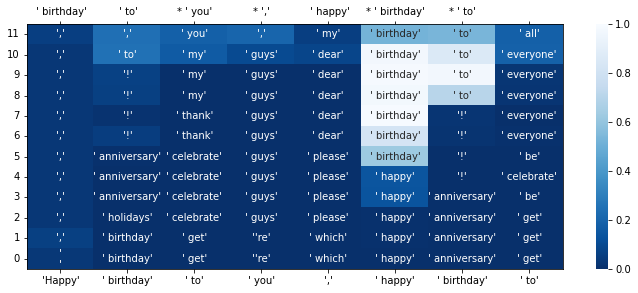

In [6]:
from transformer_utils.logit_lens.plotting import _plot_logit_lens
_plot_logit_lens(
    to_tensor(layer_logits),
    to_tensor(layer_preds),
    to_tensor(layer_probs),
    tokenizer,
    input_ids=input_ids,
    start_ix=0,
    layer_names=[i for i in range(n_layers_gpt)],
    probs=True,
    ranks=False,
    kl=False,
    top_down=False,
)

## Probing

Look at this youtube video to introduce you to probing: https://www.youtube.com/watch?v=HJn-OTNLnoE

We will use the fetch_20newsgroups dataset, and we will classify the news.
We will try to implement a small probe. Analyse each layer of GPT-2. Which layer contains most of the information we are insterested with?

Questions: 
- What is your strategy to use the internal states of gpt-2 as features for classification?
- Propose 2 other strategies that won't work.
- Try to predict the score of each layer at classifying the fetch_20newsgroups dataset.
- Implement and check your prediction.

Bonu read this: https://arxiv.org/pdf/1704.01444.pdf



In [7]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
              
twenty_train = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)

In [8]:
print(twenty_train.data[0])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



In [9]:
twenty_train.target[0]

1

In [10]:
twenty_train.target_names[twenty_train.target[0]]

'comp.graphics'

In [11]:
len(twenty_train.target)

2257

https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.CausalLMOutputWithCrossAttentions

In [ ]:
import numpy as np
import torch
from tqdm.auto import tqdm

torch.cuda.empty_cache()
embed_dim = 768
n_layers = 12
N = len(twenty_train.data)

# We only take the last token
# If you do not put everything in a single array, the memory explodes
hidden_states = np.zeros((N, n_layers, embed_dim))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activations = np.zeros((N, n_layers, embed_dim))

model = model.to(device)
model.eval()

# Fill hidden_states
with torch.no_grad():
  for i, text in tqdm(enumerate(twenty_train.data), total=N):
      input_ids = tokenizer.encode(text, return_tensors="pt", truncation=True)
      input_ids = input_ids.to(device)

      outputs = model(input_ids, output_hidden_states=True)

      # We skip the first layer only containing the embeddings
      hidden_states_np = [layer_emb.cpu().detach().numpy() for layer_emb in outputs.hidden_states[1:]]

      # We save only the last token
      hidden_states[i] = np.concatenate([layer_emb[:, -1, :] for layer_emb in hidden_states_np], axis=0)


In [ ]:
np.save("hidden_states", hidden_states)
hidden_states.shape

In [ ]:
# If you do not have a gpu, use this line.
# hidden_states = np.load("hidden_states.npy")

In [ ]:
# Check the documentation of sklearn and use those imports to score each layer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores = []
for layer_i in range(n_layers):
    X = hidden_states[:, layer_i, :]

    y = twenty_train.target[:len(X)]

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test) 
    print(layer_i, score)
  
    scores.append(score)
  

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(scores))), scores)

# Activation Atlas

With out dataset we can also try to minimally reproduce the activation atlas paper:
https://openai.com/blog/introducing-activation-atlases/


Questions:
- How to implement dimensionality reduction?
- Install umap-learn.
- Visualize the umap of the best previously selected layer. Comment.

Bonus: Plot the sentences alongside the point in the UMAP plot. Chack that everything makes sense.

In [22]:
!pip install umap-learn -q

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering library
import umap as umap

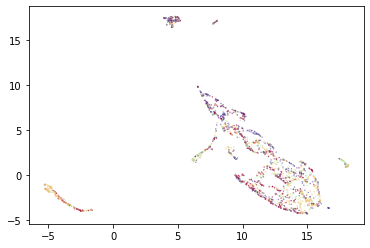

In [21]:
# Choose the best_layer
best_layer = 2
X = hidden_states_2[:, best_layer, :]
y = twenty_train.target

standard_embedding = umap.UMAP(random_state=42).fit_transform(X_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y.astype(int), s=0.1, cmap='Spectral');